# Reward Function Validation - Progress with Time Penalty

Reward functions can easily get complex to visualize once it starts taking a number of factors into account.  This notebook will help with a quick validation by running it over the track and a number of 

In [26]:
# Load the track to exercise
from math import log
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline


In [239]:

TRACK_NAME = 'Canada_training'

# Helper functions


# Visualize the Track and Waypoints

# Tracks Available::
# AWS_track                Straight_track                Oval_track
# Bowtie_track             H_track                       reinvent_base
# China_track              Mexico_track                  Canada_training

waypoints = np.load("tracks/%s.npy" % TRACK_NAME)
print("Waypoints shape: {}".format(waypoints.shape))

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

# Print some useful track analysis data
print("Centerline length: %0.2f" % l_center_line.length)
print("Track bounds: ", road_poly.bounds)
print(waypoints[0])
print("Track width: ", np.linalg.norm(waypoints[0,4:6] - waypoints[0,2:4]))
#print("Track y min/max: ", pd.DataFrame(outer_border)['y'])
road_poly

print(np.array_repr(center_line))

Waypoints shape: (203, 6)
Centerline length: 21.74
Track bounds:  (0.5871459377974991, -3.1185757246211283, 9.349370097060229, 3.0140815800413567)
[4.60918546 1.6430465  4.58646449 1.30659668 4.63079245 1.97884398]
Track width:  0.6737072087508159
array([[ 4.60918546,  1.6430465 ],
       [ 4.50431919,  1.67146498],
       [ 4.39907455,  1.69846398],
       [ 4.29348302,  1.72413248],
       [ 4.18765545,  1.74877203],
       [ 4.08169842,  1.77272302],
       [ 3.975631  ,  1.79626352],
       [ 3.86950552,  1.81977445],
       [ 3.76360047,  1.8441065 ],
       [ 3.65815759,  1.8700285 ],
       [ 3.55305755,  1.89752454],
       [ 3.44811702,  1.92617106],
       [ 3.34326446,  1.95471454],
       [ 3.23838747,  1.98214352],
       [ 3.13192952,  2.00926554],
       [ 3.02654493,  2.04065853],
       [ 2.92398453,  2.07964951],
       [ 2.82595205,  2.12832248],
       [ 2.73254597,  2.18519408],
       [ 2.64291656,  2.2447015 ],
       [ 2.55430901,  2.30580747],
       [ 2.466445

Text(4.817766904830933, 1.5820860266685486, '200')

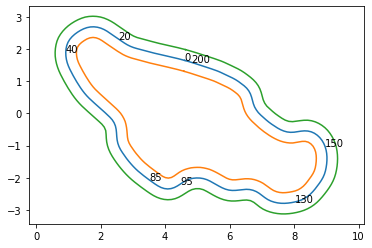

In [142]:
# scan the track and invoke the reward function for each waypoint

# Sections of Canada_Training
plt.plot(center_line[:,0:1], center_line[:,1:2])
plt.plot(inner_border[:,0:1], inner_border[:,1:2])
plt.plot(outer_border[:,0:1], outer_border[:,1:2])
plt.axis('equal')
plt.annotate('0', center_line[0])
# Straight
plt.annotate('20', center_line[20])
# Sharp left
plt.annotate('40', center_line[40])
# Straight
plt.annotate('85', center_line[85])
# Easy left
plt.annotate('95', center_line[95])
# Straight
plt.annotate('130', center_line[130])
# Easy left
plt.annotate('150', center_line[150])
# Straight
plt.annotate('200', center_line[200])

# Reward function code here

In [236]:
"""
AWS DeepRacer reward function using only progress

NOTE: This is great for maximizing individual step rewards, but the 
total episode reward will always be 100.  
"""
import bisect
import math
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

CANADA_RACE_LINE = \
np.array([[ 4.58690814,  1.62381599],
       [ 4.48738106,  1.65427416],
       [ 4.38725046,  1.68433614],
       [ 4.28650273,  1.71406729],
       [ 4.18493776,  1.74356116],
       [ 4.08163985,  1.77406108],
       [ 3.97832333,  1.80508233],
       [ 3.87512443,  1.83662263],
       [ 3.77211047,  1.86872584],
       [ 3.66931665,  1.90142676],
       [ 3.5667727 ,  1.93477735],
       [ 3.46450369,  1.96882859],
       [ 3.36251967,  2.00359792],
       [ 3.26080706,  2.03904586],
       [ 3.15932308,  2.07506231],
       [ 3.05802492,  2.11153893],
       [ 2.95687354,  2.14837789],
       [ 2.85585551,  2.18554509],
       [ 2.75883824,  2.22060616],
       [ 2.66230625,  2.25419253],
       [ 2.56644797,  2.28554876],
       [ 2.47140549,  2.31398797],
       [ 2.37731947,  2.33884628],
       [ 2.28436053,  2.35948844],
       [ 2.19273576,  2.37537617],
       [ 2.10270351,  2.38604352],
       [ 2.01457372,  2.39108769],
       [ 1.92870117,  2.39017183],
       [ 1.8455711 ,  2.38283127],
       [ 1.76540056,  2.36930326],
       [ 1.68843599,  2.34970859],
       [ 1.61491668,  2.3241611 ],
       [ 1.54562711,  2.29200111],
       [ 1.48021793,  2.25434192],
       [ 1.41931891,  2.21083539],
       [ 1.36380989,  2.16101989],
       [ 1.31511767,  2.10415835],
       [ 1.27611324,  2.03901854],
       [ 1.24632892,  1.96765326],
       [ 1.22479791,  1.89173628],
       [ 1.21095609,  1.81227247],
       [ 1.20433386,  1.73001781],
       [ 1.20472823,  1.64551202],
       [ 1.21191166,  1.55924072],
       [ 1.2256072 ,  1.47164742],
       [ 1.24549188,  1.38313076],
       [ 1.27120175,  1.29404115],
       [ 1.30233735,  1.2046781 ],
       [ 1.33847044,  1.11528869],
       [ 1.37915029,  1.02606771],
       [ 1.4239118 ,  0.93715971],
       [ 1.47239061,  0.84867972],
       [ 1.52395403,  0.76066762],
       [ 1.57824537,  0.67316842],
       [ 1.63479949,  0.58618964],
       [ 1.6931722 ,  0.49972327],
       [ 1.7529591 ,  0.41375199],
       [ 1.81381873,  0.32825241],
       [ 1.87554104,  0.24323706],
       [ 1.93603738,  0.15849485],
       [ 1.99578398,  0.07337039],
       [ 2.05473558, -0.01216384],
       [ 2.11286616, -0.09812402],
       [ 2.17012451, -0.18453837],
       [ 2.22650982, -0.27140824],
       [ 2.28208852, -0.35869942],
       [ 2.33699743, -0.44634066],
       [ 2.39133716, -0.53427951],
       [ 2.44519635, -0.62246971],
       [ 2.49858153, -0.71090791],
       [ 2.55315288, -0.80018441],
       [ 2.60840039, -0.88884569],
       [ 2.66457569, -0.97664089],
       [ 2.72193044, -1.06330053],
       [ 2.7807145 , -1.14853223],
       [ 2.84117098, -1.23201811],
       [ 2.9035955 , -1.31333661],
       [ 2.96806472, -1.39226498],
       [ 3.03478235, -1.46838728],
       [ 3.10384421, -1.54135851],
       [ 3.17529632, -1.61084721],
       [ 3.24914195, -1.67653683],
       [ 3.32534623, -1.7381322 ],
       [ 3.40384079, -1.79536844],
       [ 3.48452863, -1.84802159],
       [ 3.56728929, -1.89592025],
       [ 3.65198431, -1.93895751],
       [ 3.73846297, -1.97710206],
       [ 3.82656835, -2.01040731],
       [ 3.91614359, -2.03901717],
       [ 4.00703771, -2.06316761],
       [ 4.09910987, -2.08318352],
       [ 4.19223006, -2.09947197],
       [ 4.28627422, -2.11251339],
       [ 4.38111294, -2.12285416],
       [ 4.47659463, -2.13110561],
       [ 4.57252446, -2.13796276],
       [ 4.66872742, -2.14399834],
       [ 4.77000868, -2.1500424 ],
       [ 4.87130911, -2.15666494],
       [ 4.97263773, -2.16412528],
       [ 5.07400359, -2.17267168],
       [ 5.17541634, -2.18256141],
       [ 5.276882  , -2.19394462],
       [ 5.37840338, -2.20689502],
       [ 5.47997997, -2.22142266],
       [ 5.58160783, -2.23748358],
       [ 5.68327968, -2.25499019],
       [ 5.78498545, -2.27382221],
       [ 5.88671326, -2.29383597],
       [ 5.98845084, -2.31487017],
       [ 6.09018733, -2.33675134],
       [ 6.19191516, -2.35929273],
       [ 6.29362868, -2.38238388],
       [ 6.39532399, -2.4059246 ],
       [ 6.49699807, -2.42983908],
       [ 6.59782498, -2.45315915],
       [ 6.69849498, -2.47569571],
       [ 6.79894984, -2.49704858],
       [ 6.89913314, -2.51677778],
       [ 6.99897986, -2.53439931],
       [ 7.09842452, -2.54951355],
       [ 7.19737634, -2.56170081],
       [ 7.29572336, -2.5705693 ],
       [ 7.39333932, -2.57579568],
       [ 7.49005004, -2.57697023],
       [ 7.58564678, -2.57369543],
       [ 7.67988935, -2.56561554],
       [ 7.77249828, -2.55239836],
       [ 7.86316118, -2.53376514],
       [ 7.9515388 , -2.5095112 ],
       [ 8.03726886, -2.47951198],
       [ 8.11997016, -2.4437251 ],
       [ 8.19924737, -2.40219134],
       [ 8.27469619, -2.35503399],
       [ 8.3459086 , -2.30245627],
       [ 8.41247792, -2.2447372 ],
       [ 8.47400385, -2.18222628],
       [ 8.53009729, -2.11533745],
       [ 8.58038524, -2.04454242],
       [ 8.62451568, -1.97036359],
       [ 8.66216268, -1.89336638],
       [ 8.69303168, -1.81415101],
       [ 8.71686515, -1.73334328],
       [ 8.73344843, -1.65158445],
       [ 8.74261584, -1.56951973],
       [ 8.74425677, -1.48778563],
       [ 8.73832158, -1.40699594],
       [ 8.72482696, -1.32772683],
       [ 8.70386036, -1.25050128],
       [ 8.67558293, -1.17577369],
       [ 8.64023685, -1.10391207],
       [ 8.59852451, -1.03498832],
       [ 8.54979569, -0.96969581],
       [ 8.49515075, -0.90777692],
       [ 8.43520907, -0.84908712],
       [ 8.37033534, -0.79355949],
       [ 8.30107407, -0.74094638],
       [ 8.22800612, -0.69091177],
       [ 8.15174535, -0.64305094],
       [ 8.07294303, -0.59690999],
       [ 7.99227282, -0.55201739],
       [ 7.91043405, -0.50789554],
       [ 7.82183413, -0.45934669],
       [ 7.73385588, -0.40987187],
       [ 7.64675315, -0.35910129],
       [ 7.56075882, -0.30670408],
       [ 7.47607845, -0.25239782],
       [ 7.39287   , -0.19597687],
       [ 7.31123826, -0.1373178 ],
       [ 7.23123156, -0.07638045],
       [ 7.15283838, -0.01320887],
       [ 7.07598551,  0.05206999],
       [ 7.00053998,  0.11925234],
       [ 6.92631822,  0.18807251],
       [ 6.85309405,  0.25821532],
       [ 6.78067486,  0.32941673],
       [ 6.70890695,  0.40146852],
       [ 6.6378418 ,  0.47162292],
       [ 6.56615283,  0.54079899],
       [ 6.49373643,  0.60882247],
       [ 6.42044865,  0.67545007],
       [ 6.34617612,  0.74048232],
       [ 6.27081516,  0.80373199],
       [ 6.19423915,  0.86497245],
       [ 6.1163545 ,  0.92403245],
       [ 6.03709717,  0.98079546],
       [ 5.9564273 ,  1.03519585],
       [ 5.87432458,  1.08721547],
       [ 5.79078409,  1.1368797 ],
       [ 5.70581254,  1.18425258],
       [ 5.61942522,  1.22943081],
       [ 5.53164382,  1.27253724],
       [ 5.44249526,  1.31371417],
       [ 5.35201168,  1.35311694],
       [ 5.26023149,  1.39090822],
       [ 5.16720118,  1.42725323],
       [ 5.07297767,  1.46231616],
       [ 4.97763079,  1.49625767],
       [ 4.88124504,  1.52923333],
       [ 4.78391895,  1.5613916 ],
       [ 4.68575941,  1.59286997],
       [ 4.58690814,  1.62381599]])

OVAL_RACE_LINE = \
np.array([[2.98364267, 0.99085028],
       [3.17421598, 0.97620247],
       [3.36671419, 0.96649433],
       [3.56058581, 0.960703  ],
       [3.75535101, 0.95777286],
       [3.95062567, 0.95669888],
       [4.14610792, 0.95653044],
       [4.34159153, 0.95639902],
       [4.53707359, 0.95630106],
       [4.7325572 , 0.9562338 ],
       [4.92803925, 0.95619736],
       [5.12352151, 0.95618474],
       [5.31900376, 0.95620671],
       [5.51448601, 0.95624661],
       [5.70979907, 0.95683811],
       [5.90453462, 0.95904602],
       [6.09820605, 0.96402984],
       [6.2902894 , 0.97289169],
       [6.48020848, 0.98670902],
       [6.66733244, 1.00652711],
       [6.85092153, 1.03345045],
       [7.0301681 , 1.06852883],
       [7.20417779, 1.11277401],
       [7.37191408, 1.16722165],
       [7.5320838 , 1.23304026],
       [7.68318939, 1.31135122],
       [7.82337587, 1.40332219],
       [7.95010759, 1.5102931 ],
       [8.05936795, 1.63382532],
       [8.1520362 , 1.77028048],
       [8.22819348, 1.9172171 ],
       [8.28787224, 2.07238766],
       [8.3308672 , 2.23370267],
       [8.35693826, 2.39905148],
       [8.36600944, 2.56628126],
       [8.35817837, 2.73328038],
       [8.3337493 , 2.89807127],
       [8.29289897, 3.05877775],
       [8.23595591, 3.21364943],
       [8.16298155, 3.36089086],
       [8.07359073, 3.49836566],
       [7.9671104 , 3.62340215],
       [7.8425753 , 3.73235683],
       [7.70459723, 3.82715581],
       [7.55530675, 3.90855117],
       [7.39646948, 3.97742213],
       [7.22950707, 4.03458291],
       [7.05575741, 4.08103305],
       [6.87635781, 4.11772732],
       [6.69236277, 4.14572764],
       [6.50477569, 4.16628195],
       [6.3144696 , 4.18067204],
       [6.12216363, 4.19011328],
       [5.92844134, 4.19573362],
       [5.73377501, 4.19857523],
       [5.53854858, 4.19960687],
       [5.34308058, 4.19975659],
       [5.14759562, 4.19980232],
       [4.95211356, 4.19981647],
       [4.75663015, 4.19980096],
       [4.56114789, 4.19975794],
       [4.36566429, 4.19968663],
       [4.17018339, 4.19958005],
       [3.97470114, 4.19944052],
       [3.79232065, 4.19861421],
       [3.62484561, 4.19654801],
       [3.46494018, 4.19276608],
       [3.30661124, 4.18665152],
       [3.14553467, 4.17732632],
       [2.97916312, 4.16360559],
       [2.80731174, 4.14417676],
       [2.63194691, 4.11772299],
       [2.45616369, 4.08308572],
       [2.28299749, 4.03924655],
       [2.11489618, 3.98520214],
       [1.9537057 , 3.92004072],
       [1.80126696, 3.84251329],
       [1.65974801, 3.75114985],
       [1.53187772, 3.64444942],
       [1.42163922, 3.52095515],
       [1.32850831, 3.38416482],
       [1.25247416, 3.23670747],
       [1.19359575, 3.08103347],
       [1.15181546, 2.91953305],
       [1.12709231, 2.75444834],
       [1.11919456, 2.5878978 ],
       [1.12767868, 2.42180181],
       [1.15224643, 2.25790639],
       [1.19257573, 2.09783843],
       [1.24854056, 1.94320292],
       [1.32072641, 1.79597821],
       [1.40962022, 1.65837756],
       [1.51614302, 1.53330828],
       [1.64132309, 1.42464859],
       [1.77997335, 1.3300841 ],
       [1.92991192, 1.24882412],
       [2.08935204, 1.17997642],
       [2.2568989 , 1.12278679],
       [2.43128201, 1.07640317],
       [2.6112811 , 1.03978189],
       [2.79573133, 1.0116745 ],
       [2.98364267, 0.99085028]])

NEW_YORK_RACE_LINE = \
np.array([[ 4.30602002e+00,  4.16689295e-01],
       [ 4.42467643e+00,  4.25552511e-01],
       [ 4.54319764e+00,  4.35630403e-01],
       [ 4.66157239e+00,  4.46861868e-01],
       [ 4.77979176e+00,  4.59188765e-01],
       [ 4.89784882e+00,  4.72555491e-01],
       [ 5.01573837e+00,  4.86908481e-01],
       [ 5.13345651e+00,  5.02196201e-01],
       [ 5.25099990e+00,  5.18370626e-01],
       [ 5.36836401e+00,  5.35392425e-01],
       [ 5.48554026e+00,  5.53240340e-01],
       [ 5.60251390e+00,  5.71916599e-01],
       [ 5.71926030e+00,  5.91455330e-01],
       [ 5.83575047e+00,  6.11900354e-01],
       [ 5.95188486e+00,  6.33513704e-01],
       [ 6.06752352e+00,  6.56622497e-01],
       [ 6.18245374e+00,  6.81677389e-01],
       [ 6.29633821e+00,  7.09324653e-01],
       [ 6.40863259e+00,  7.40492707e-01],
       [ 6.51847078e+00,  7.76456173e-01],
       [ 6.62448746e+00,  8.18911520e-01],
       [ 6.72393614e+00,  8.70841397e-01],
       [ 6.81346977e+00,  9.34895113e-01],
       [ 6.88884222e+00,  1.01365165e+00],
       [ 6.95143686e+00,  1.10320814e+00],
       [ 7.00335943e+00,  1.19995177e+00],
       [ 7.04637546e+00,  1.30138513e+00],
       [ 7.08227075e+00,  1.40573850e+00],
       [ 7.11227075e+00,  1.51199394e+00],
       [ 7.13726675e+00,  1.61951887e+00],
       [ 7.15816743e+00,  1.72786357e+00],
       [ 7.17539629e+00,  1.83678687e+00],
       [ 7.18925809e+00,  1.94611556e+00],
       [ 7.19999390e+00,  2.05571821e+00],
       [ 7.20780867e+00,  2.16549109e+00],
       [ 7.21288216e+00,  2.27535045e+00],
       [ 7.21537409e+00,  2.38522795e+00],
       [ 7.21542856e+00,  2.49506741e+00],
       [ 7.21317872e+00,  2.60482256e+00],
       [ 7.20875100e+00,  2.71445517e+00],
       [ 7.20226867e+00,  2.82393374e+00],
       [ 7.19385472e+00,  2.93323251e+00],
       [ 7.18362522e+00,  3.04232965e+00],
       [ 7.17167682e+00,  3.15120486e+00],
       [ 7.15810165e+00,  3.25983973e+00],
       [ 7.14279404e+00,  3.36818318e+00],
       [ 7.12546339e+00,  3.47613692e+00],
       [ 7.10576690e+00,  3.58356997e+00],
       [ 7.08281395e+00,  3.69017273e+00],
       [ 7.05547588e+00,  3.79544629e+00],
       [ 7.02236153e+00,  3.89859680e+00],
       [ 6.98105733e+00,  3.99796597e+00],
       [ 6.92936532e+00,  4.09114650e+00],
       [ 6.86412146e+00,  4.17361784e+00],
       [ 6.78765212e+00,  4.24500373e+00],
       [ 6.70280139e+00,  4.30687376e+00],
       [ 6.61198764e+00,  4.36142273e+00],
       [ 6.51683439e+00,  4.41037470e+00],
       [ 6.41809710e+00,  4.45452505e+00],
       [ 6.31634645e+00,  4.49450665e+00],
       [ 6.21202982e+00,  4.53084152e+00],
       [ 6.10544948e+00,  4.56388553e+00],
       [ 5.99684062e+00,  4.59392433e+00],
       [ 5.88641684e+00,  4.62123126e+00],
       [ 5.77438515e+00,  4.64608510e+00],
       [ 5.66093744e+00,  4.66875315e+00],
       [ 5.54626126e+00,  4.68950521e+00],
       [ 5.43035249e+00,  4.70831521e+00],
       [ 5.31318252e+00,  4.72511597e+00],
       [ 5.19454423e+00,  4.73954855e+00],
       [ 5.07418845e+00,  4.75117350e+00],
       [ 4.95122856e+00,  4.75845689e+00],
       [ 4.81066002e+00,  4.75893022e+00],
       [ 4.67187102e+00,  4.78208783e+00],
       [ 4.53750448e+00,  4.82403992e+00],
       [ 4.40827265e+00,  4.85257921e+00],
       [ 4.27949291e+00,  4.87346740e+00],
       [ 4.15143207e+00,  4.88865553e+00],
       [ 4.02415540e+00,  4.89948035e+00],
       [ 3.89763534e+00,  4.90688852e+00],
       [ 3.77182132e+00,  4.91152115e+00],
       [ 3.64665791e+00,  4.91383647e+00],
       [ 3.52208999e+00,  4.91418221e+00],
       [ 3.39808573e+00,  4.91276899e+00],
       [ 3.27462516e+00,  4.90973771e+00],
       [ 3.15169367e+00,  4.90519405e+00],
       [ 3.02927995e+00,  4.89922175e+00],
       [ 2.90740863e+00,  4.89180188e+00],
       [ 2.78603886e+00,  4.88308296e+00],
       [ 2.66516591e+00,  4.87310963e+00],
       [ 2.54478662e+00,  4.86191899e+00],
       [ 2.42489924e+00,  4.84954181e+00],
       [ 2.30550084e+00,  4.83600920e+00],
       [ 2.18658562e+00,  4.82135702e+00],
       [ 2.06816795e+00,  4.80557364e+00],
       [ 1.95025135e+00,  4.78867232e+00],
       [ 1.83283018e+00,  4.77068643e+00],
       [ 1.71589213e+00,  4.75166277e+00],
       [ 1.59941676e+00,  4.73166377e+00],
       [ 1.48337149e+00,  4.71077509e+00],
       [ 1.36776847e+00,  4.68899038e+00],
       [ 1.25263971e+00,  4.66626737e+00],
       [ 1.13805444e+00,  4.64249778e+00],
       [ 1.02413306e+00,  4.61748856e+00],
       [ 9.10989791e-01,  4.59107246e+00],
       [ 7.98931908e-01,  4.56276571e+00],
       [ 6.88360305e-01,  4.53198681e+00],
       [ 5.80046607e-01,  4.49767679e+00],
       [ 4.75088612e-01,  4.45854475e+00],
       [ 3.75153598e-01,  4.41297438e+00],
       [ 2.82585957e-01,  4.35926513e+00],
       [ 2.01357564e-01,  4.29532799e+00],
       [ 1.33034091e-01,  4.22233619e+00],
       [ 7.66617460e-02,  4.14291755e+00],
       [ 3.00662105e-02,  4.05938817e+00],
       [-7.17895242e-03,  3.97273305e+00],
       [-3.41694636e-02,  3.88349983e+00],
       [-5.10257229e-02,  3.79251564e+00],
       [-6.00551725e-02,  3.70063240e+00],
       [-6.24982250e-02,  3.60824575e+00],
       [-5.89858739e-02,  3.51558849e+00],
       [-5.00227406e-02,  3.42282740e+00],
       [-3.56189352e-02,  3.33009222e+00],
       [-1.43176664e-02,  3.23759066e+00],
       [ 1.63317971e-02,  3.14583679e+00],
       [ 5.42866061e-02,  3.05501741e+00],
       [ 9.85372845e-02,  2.96522072e+00],
       [ 1.48256989e-01,  2.87646918e+00],
       [ 2.02661948e-01,  2.78872659e+00],
       [ 2.61226626e-01,  2.70196874e+00],
       [ 3.23635687e-01,  2.61619869e+00],
       [ 3.89577636e-01,  2.53140851e+00],
       [ 4.58814376e-01,  2.44760402e+00],
       [ 5.31467330e-01,  2.36490825e+00],
       [ 6.07918286e-01,  2.28356835e+00],
       [ 6.88590965e-01,  2.20389670e+00],
       [ 7.74825861e-01,  2.12669357e+00],
       [ 8.68364211e-01,  2.05321606e+00],
       [ 9.73052141e-01,  1.98664059e+00],
       [ 1.10129616e+00,  1.92957505e+00],
       [ 1.20961196e+00,  1.84068115e+00],
       [ 1.29466328e+00,  1.72892424e+00],
       [ 1.35584178e+00,  1.60219568e+00],
       [ 1.42247663e+00,  1.49647569e+00],
       [ 1.49503842e+00,  1.39938161e+00],
       [ 1.57180212e+00,  1.30874297e+00],
       [ 1.65161708e+00,  1.22295995e+00],
       [ 1.73393814e+00,  1.14126497e+00],
       [ 1.81841506e+00,  1.06315721e+00],
       [ 1.90480986e+00,  9.88292655e-01],
       [ 1.99292305e+00,  9.16373240e-01],
       [ 2.08258245e+00,  8.47134401e-01],
       [ 2.17368880e+00,  7.80430111e-01],
       [ 2.26626138e+00,  7.16320150e-01],
       [ 2.36038863e+00,  6.54988368e-01],
       [ 2.45656996e+00,  5.97370091e-01],
       [ 2.55542854e+00,  5.44664432e-01],
       [ 2.66086300e+00,  5.04185892e-01],
       [ 2.77129574e+00,  4.73079828e-01],
       [ 2.88498584e+00,  4.48967001e-01],
       [ 3.00082056e+00,  4.30550427e-01],
       [ 3.11801206e+00,  4.16785392e-01],
       [ 3.23602448e+00,  4.06759178e-01],
       [ 3.35453119e+00,  3.99812439e-01],
       [ 3.47332902e+00,  3.95461185e-01],
       [ 3.59228756e+00,  3.93342235e-01],
       [ 3.71132084e+00,  3.93179296e-01],
       [ 3.83037077e+00,  3.94797842e-01],
       [ 3.94939473e+00,  3.98068276e-01],
       [ 4.06836026e+00,  4.02873096e-01],
       [ 4.18724233e+00,  4.09105775e-01],
       [ 4.30602002e+00,  4.16689295e-01]])

BOWTIE_RACE_LINE = \
np.array([[2.09781331, 1.04053482],
       [2.19197213, 1.03895551],
       [2.28696905, 1.04589252],
       [2.38232754, 1.06081783],
       [2.47767993, 1.08300658],
       [2.5727803 , 1.11152832],
       [2.66750745, 1.14525137],
       [2.76183363, 1.18308662],
       [2.85579527, 1.22401192],
       [2.94946828, 1.26709028],
       [3.04439394, 1.312165  ],
       [3.13979376, 1.35532158],
       [3.23581524, 1.39581292],
       [3.33256579, 1.43293727],
       [3.43011995, 1.46598253],
       [3.52849841, 1.49430999],
       [3.62768443, 1.51723584],
       [3.7275946 , 1.53416474],
       [3.82807101, 1.54471733],
       [3.92890746, 1.54867802],
       [4.02987102, 1.54598083],
       [4.1307231 , 1.53670372],
       [4.23123989, 1.52106291],
       [4.33123116, 1.49940557],
       [4.43055616, 1.47220119],
       [4.52913558, 1.44003297],
       [4.62695924, 1.40359157],
       [4.72408845, 1.36366928],
       [4.82063059, 1.32105466],
       [4.91671998, 1.27649474],
       [5.01250076, 1.23066871],
       [5.10041987, 1.18922129],
       [5.18821558, 1.149563  ],
       [5.27580018, 1.11278942],
       [5.36307848, 1.07990192],
       [5.44994064, 1.05186025],
       [5.53627975, 1.02937112],
       [5.62198301, 1.01301352],
       [5.70690994, 1.00340285],
       [5.79089414, 1.00107632],
       [5.8737453 , 1.00639816],
       [5.9552342 , 1.0196011 ],
       [6.03507965, 1.04080788],
       [6.11293975, 1.07004179],
       [6.1884103 , 1.10723276],
       [6.26103265, 1.15222072],
       [6.33031219, 1.20475813],
       [6.39574645, 1.26451289],
       [6.4568603 , 1.33107345],
       [6.51324392, 1.40395688],
       [6.56458865, 1.48262047],
       [6.61071479, 1.56647731],
       [6.65158548, 1.65491579],
       [6.68730146, 1.74732325],
       [6.71807524, 1.84311174],
       [6.74419033, 1.94174167],
       [6.76595593, 2.0427372 ],
       [6.78366677, 2.14568968],
       [6.79757228, 2.25024735],
       [6.80785551, 2.35609104],
       [6.81462073, 2.4628976 ],
       [6.81788905, 2.57030201],
       [6.8176023 , 2.677881  ],
       [6.81363392, 2.78517643],
       [6.80580296, 2.89174173],
       [6.79388691, 2.99716853],
       [6.77763171, 3.10107794],
       [6.75676036, 3.20309291],
       [6.73098469, 3.30281191],
       [6.70002175, 3.39979209],
       [6.66361342, 3.49354157],
       [6.62154646, 3.58351782],
       [6.57367067, 3.6691295 ],
       [6.51991464, 3.74974136],
       [6.46030104, 3.82468521],
       [6.39496342, 3.89328089],
       [6.32415956, 3.9548656 ],
       [6.24827387, 4.00882542],
       [6.16780561, 4.05462432],
       [6.08334544, 4.09182938],
       [5.99554526, 4.1201329 ],
       [5.90508495, 4.13937131],
       [5.81263912, 4.14954068],
       [5.71884549, 4.15080773],
       [5.62427662, 4.14351565],
       [5.52941627, 4.12818439],
       [5.43464164, 4.10550584],
       [5.3402124 , 4.07633555],
       [5.24626685, 4.04168379],
       [5.15282721, 4.00269639],
       [5.05982363, 3.9605614 ],
       [4.96711398, 3.91651251],
       [4.87146409, 3.87195139],
       [4.77537108, 3.8290678 ],
       [4.67864127, 3.78872972],
       [4.58113475, 3.75175303],
       [4.48276569, 3.71893765],
       [4.38352716, 3.69097195],
       [4.28348609, 3.66843175],
       [4.18277413, 3.65177384],
       [4.08157408, 3.64132686],
       [3.98010275, 3.63728121],
       [3.87859135, 3.63967978],
       [3.77726535, 3.64841299],
       [3.67632592, 3.66322111],
       [3.57593434, 3.68370058],
       [3.47619973, 3.70930954],
       [3.37721025, 3.73962623],
       [3.27905928, 3.77440074],
       [3.1818249 , 3.81337983],
       [3.0856276 , 3.85652513],
       [2.99062012, 3.90386916],
       [2.89758386, 3.95530184],
       [2.80372402, 4.00159988],
       [2.70904273, 4.04250876],
       [2.61365045, 4.07755267],
       [2.51775824, 4.10651529],
       [2.42160441, 4.128987  ],
       [2.32548299, 4.14455664],
       [2.22974861, 4.15281183],
       [2.13482605, 4.15333416],
       [2.04121975, 4.14571342],
       [1.94951429, 4.1295862 ],
       [1.86034703, 4.10474587],
       [1.77437911, 4.07116916],
       [1.69226481, 4.02900705],
       [1.6146196 , 3.97856481],
       [1.54198877, 3.9202768 ],
       [1.47481877, 3.85467944],
       [1.41343315, 3.78238433],
       [1.35801544, 3.70405253],
       [1.30860171, 3.62036983],
       [1.26508649, 3.53202229],
       [1.22724426, 3.43967171],
       [1.19476428, 3.34393286],
       [1.16729121, 3.24535661],
       [1.14446299, 3.14442252],
       [1.12594283, 3.04154138],
       [1.11144498, 2.93706773],
       [1.10075346, 2.83132333],
       [1.09373255, 2.72463074],
       [1.09032961, 2.61734807],
       [1.09057152, 2.50988625],
       [1.09455635, 2.40269412],
       [1.10244239, 2.29622166],
       [1.11443659, 2.19089254],
       [1.13078319, 2.08710386],
       [1.1517521 , 1.98524575],
       [1.17762507, 1.8857247 ],
       [1.20867875, 1.78898068],
       [1.24516608, 1.69549693],
       [1.28729933, 1.60580523],
       [1.33523507, 1.52048761],
       [1.38905615, 1.44017101],
       [1.44874946, 1.36551182],
       [1.51418488, 1.29717229],
       [1.58510372, 1.23579357],
       [1.6611208 , 1.18196953],
       [1.74173923, 1.13622227],
       [1.82637413, 1.0989792 ],
       [1.91438177, 1.07055094],
       [2.00509107, 1.05111065],
       [2.09781331, 1.04053482]])

LONDON_RACE_LINE = \
np.array([[5.06645943, 0.67304432],
       [5.15215044, 0.66884136],
       [5.23750839, 0.66567809],
       [5.32250931, 0.66362216],
       [5.40710322, 0.66281883],
       [5.49124014, 0.66340988],
       [5.57476543, 0.66584729],
       [5.65748665, 0.67067721],
       [5.73911525, 0.67869662],
       [5.81908202, 0.69142236],
       [5.89655499, 0.71084582],
       [5.97007873, 0.73964802],
       [6.03821661, 0.77795458],
       [6.10144693, 0.82250813],
       [6.16065094, 0.87123043],
       [6.21662064, 0.92288058],
       [6.26997477, 0.97668445],
       [6.32116462, 1.03214837],
       [6.37061939, 1.0888739 ],
       [6.41854214, 1.14666774],
       [6.46508604, 1.20538894],
       [6.510371  , 1.26493069],
       [6.55449579, 1.32520811],
       [6.59754615, 1.38615038],
       [6.63960116, 1.44769522],
       [6.68073769, 1.50978522],
       [6.72103123, 1.57236663],
       [6.76055083, 1.6353918 ],
       [6.79934909, 1.6988242 ],
       [6.83747839, 1.76262855],
       [6.87493017, 1.82680322],
       [6.91168245, 1.89135285],
       [6.9476955 , 1.95629061],
       [6.98283384, 2.02167699],
       [7.0169373 , 2.08758033],
       [7.04951581, 2.15421836],
       [7.07999109, 2.2218177 ],
       [7.10746699, 2.29068722],
       [7.13057395, 2.36119683],
       [7.14747874, 2.43359761],
       [7.15552575, 2.50774982],
       [7.15361001, 2.58255999],
       [7.14578559, 2.65719037],
       [7.13186383, 2.73128689],
       [7.10782745, 2.80355499],
       [7.07685277, 2.87386393],
       [7.04048481, 2.9422636 ],
       [6.99983519, 3.00887438],
       [6.95578556, 3.0738733 ],
       [6.90895016, 3.13741365],
       [6.85976115, 3.19961749],
       [6.80853288, 3.26058186],
       [6.75550421, 3.32038645],
       [6.70082279, 3.37907064],
       [6.64458988, 3.43665333],
       [6.58688338, 3.49314351],
       [6.52776635, 3.54854411],
       [6.46729251, 3.60285481],
       [6.40550995, 3.65607423],
       [6.34246164, 3.70819955],
       [6.27818204, 3.75922258],
       [6.21269035, 3.80912225],
       [6.14598888, 3.85786156],
       [6.07807833, 3.90540068],
       [6.00896479, 3.95170333],
       [5.93865899, 3.99673631],
       [5.86717453, 4.04046809],
       [5.7945272 , 4.08286837],
       [5.72073516, 4.12390835],
       [5.64581914, 4.16356115],
       [5.56980256, 4.20180208],
       [5.49271141, 4.23860856],
       [5.41457386, 4.27395987],
       [5.33541991, 4.30783683],
       [5.25528088, 4.34022135],
       [5.17418911, 4.37109603],
       [5.0921776 , 4.40044388],
       [5.00927978, 4.42824799],
       [4.92552945, 4.45449139],
       [4.8409607 , 4.47915694],
       [4.7556081 , 4.5022274 ],
       [4.66950694, 4.52368554],
       [4.58269361, 4.54351443],
       [4.49520607, 4.56169777],
       [4.40708444, 4.57822033],
       [4.31837153, 4.59306832],
       [4.22911346, 4.60622991],
       [4.13936018, 4.61769558],
       [4.04916584, 4.62745847],
       [3.95858909, 4.6355146 ],
       [3.86769318, 4.64186307],
       [3.7765458 , 4.64650603],
       [3.68521883, 4.64944863],
       [3.59378774, 4.65069884],
       [3.50233088, 4.65026724],
       [3.41092865, 4.64816669],
       [3.31966239, 4.6444121 ],
       [3.22861336, 4.63902006],
       [3.13786158, 4.63200868],
       [3.04748466, 4.62339734],
       [2.95755675, 4.61320666],
       [2.8681475 , 4.60145845],
       [2.77932114, 4.58817586],
       [2.69113566, 4.57338357],
       [2.60364216, 4.55710809],
       [2.51688419, 4.53937819],
       [2.43089735, 4.5202253 ],
       [2.34570887, 4.49968414],
       [2.26133735, 4.4777932 ],
       [2.17779246, 4.4545954 ],
       [2.09507488, 4.43013856],
       [2.01317635, 4.40447581],
       [1.93208001, 4.37766553],
       [1.85176137, 4.34977069],
       [1.77218963, 4.32085766],
       [1.69332884, 4.29099532],
       [1.61513744, 4.26025615],
       [1.53757313, 4.22871049],
       [1.46057923, 4.19644367],
       [1.38424158, 4.16336143],
       [1.30864956, 4.1293706 ],
       [1.2339778 , 4.09428159],
       [1.1604722 , 4.05783249],
       [1.08851053, 4.01962716],
       [1.01887803, 3.97885621],
       [0.9524433 , 3.9347037 ],
       [0.89070862, 3.88584109],
       [0.83579647, 3.83067269],
       [0.79101935, 3.7676338 ],
       [0.75456787, 3.69977223],
       [0.72438922, 3.62912511],
       [0.69880664, 3.55684858],
       [0.67701591, 3.48347508],
       [0.65843687, 3.40934679],
       [0.64262971, 3.33469419],
       [0.62926091, 3.25967662],
       [0.61811548, 3.18440282],
       [0.60904695, 3.10895233],
       [0.60194185, 3.03338743],
       [0.5967048 , 2.95775885],
       [0.5932596 , 2.88210892],
       [0.5915514 , 2.80647385],
       [0.59164045, 2.73089004],
       [0.59328377, 2.65537803],
       [0.59653313, 2.57996497],
       [0.60135932, 2.50467345],
       [0.60774349, 2.4295249 ],
       [0.61566298, 2.3545385 ],
       [0.62508067, 2.27973005],
       [0.6359433 , 2.20511142],
       [0.64818201, 2.13069026],
       [0.66171315, 2.05646989],
       [0.67643586, 1.98244862],
       [0.69222877, 1.90861885],
       [0.70901491, 1.83497876],
       [0.72681541, 1.76154482],
       [0.74591469, 1.68839482],
       [0.76662985, 1.61563111],
       [0.78947113, 1.54343104],
       [0.81529828, 1.47213235],
       [0.84520297, 1.40228241],
       [0.88102616, 1.3350748 ],
       [0.92380828, 1.27208869],
       [0.97184784, 1.21328774],
       [1.0237515 , 1.15812597],
       [1.07931831, 1.10685586],
       [1.13845621, 1.05985538],
       [1.20015817, 1.01621009],
       [1.2640097 , 0.97554622],
       [1.3297245 , 0.93759343],
       [1.39708047, 0.90212637],
       [1.46593636, 0.86901039],
       [1.53679463, 0.83917915],
       [1.60989309, 0.81327371],
       [1.68492674, 0.79099687],
       [1.76182825, 0.77245025],
       [1.84070369, 0.75815482],
       [1.92099595, 0.74714758],
       [2.00230373, 0.73862602],
       [2.08443611, 0.73220752],
       [2.16725182, 0.72759456],
       [2.25064302, 0.72454996],
       [2.33453864, 0.72291855],
       [2.41888692, 0.72258748],
       [2.50364571, 0.72346356],
       [2.58877744, 0.72546067],
       [2.67424568, 0.72849064],
       [2.76001596, 0.73246663],
       [2.84606242, 0.73732551],
       [2.93236199, 0.74301141],
       [3.01889914, 0.74949311],
       [3.10567061, 0.75678265],
       [3.19268985, 0.7649569 ],
       [3.2800031 , 0.77423278],
       [3.36765157, 0.78485068],
       [3.4557308 , 0.79739179],
       [3.54429036, 0.81261034],
       [3.63118394, 0.83152164],
       [3.71934839, 0.8431505 ],
       [3.80887245, 0.84826726],
       [3.899786  , 0.84726772],
       [3.99189906, 0.84003324],
       [4.08515821, 0.82727494],
       [4.17929992, 0.80753482],
       [4.27391742, 0.77959317],
       [4.36492636, 0.75793451],
       [4.45477959, 0.74023253],
       [4.54379668, 0.72532595],
       [4.63213165, 0.7126657 ],
       [4.71990076, 0.70184748],
       [4.80717439, 0.69262697],
       [4.89399986, 0.6848401 ],
       [4.98041611, 0.6783534 ],
       [5.06645943, 0.67304432]])

TOKYO_RACE_LINE = \
np.array([[ 3.99688433e+00, -2.39808512e+00],
       [ 4.10848682e+00, -2.39808512e+00],
       [ 4.22011741e+00, -2.39808512e+00],
       [ 4.33172862e+00, -2.39808483e+00],
       [ 4.44335029e+00, -2.39808512e+00],
       [ 4.55498844e+00, -2.39808512e+00],
       [ 4.66657175e+00, -2.39808512e+00],
       [ 4.77816416e+00, -2.39808512e+00],
       [ 4.88967538e+00, -2.39808512e+00],
       [ 5.00123698e+00, -2.39808512e+00],
       [ 5.11282067e+00, -2.39808512e+00],
       [ 5.22445223e+00, -2.39808512e+00],
       [ 5.33606111e+00, -2.39808512e+00],
       [ 5.44766128e+00, -2.39808483e+00],
       [ 5.55926377e+00, -2.39808512e+00],
       [ 5.67088409e+00, -2.39808512e+00],
       [ 5.78251080e+00, -2.39808512e+00],
       [ 5.89611313e+00, -2.39801273e+00],
       [ 6.02385195e+00, -2.39739031e+00],
       [ 6.18058569e+00, -2.39512793e+00],
       [ 6.34701788e+00, -2.39004106e+00],
       [ 6.51199333e+00, -2.38131187e+00],
       [ 6.67076597e+00, -2.36841577e+00],
       [ 6.82135234e+00, -2.35107151e+00],
       [ 6.96314278e+00, -2.32917228e+00],
       [ 7.09615209e+00, -2.30265579e+00],
       [ 7.22073001e+00, -2.27148159e+00],
       [ 7.33738851e+00, -2.23561675e+00],
       [ 7.44672461e+00, -2.19504866e+00],
       [ 7.54919778e+00, -2.14967306e+00],
       [ 7.64521355e+00, -2.09935731e+00],
       [ 7.73518321e+00, -2.04400328e+00],
       [ 7.81950989e+00, -1.98355754e+00],
       [ 7.89856176e+00, -1.91800435e+00],
       [ 7.97264746e+00, -1.84735038e+00],
       [ 8.04200067e+00, -1.77160740e+00],
       [ 8.10677641e+00, -1.69077745e+00],
       [ 8.16705740e+00, -1.60484290e+00],
       [ 8.22286719e+00, -1.51376274e+00],
       [ 8.27418743e+00, -1.41747647e+00],
       [ 8.32097675e+00, -1.31591651e+00],
       [ 8.36318947e+00, -1.20902939e+00],
       [ 8.40079281e+00, -1.09680457e+00],
       [ 8.43378167e+00, -9.79308187e-01],
       [ 8.46219084e+00, -8.56717030e-01],
       [ 8.48610448e+00, -7.29346620e-01],
       [ 8.50566419e+00, -5.97667095e-01],
       [ 8.52107773e+00, -4.62302024e-01],
       [ 8.53261906e+00, -3.24000460e-01],
       [ 8.54057494e+00, -1.83558092e-01],
       [ 8.54529992e+00, -4.18058973e-02],
       [ 8.54714938e+00,  1.00476037e-01],
       [ 8.54646979e+00,  2.42591011e-01],
       [ 8.54355605e+00,  3.83919102e-01],
       [ 8.53872670e+00,  5.23943725e-01],
       [ 8.53226852e+00,  6.62254929e-01],
       [ 8.52444774e+00,  7.98561668e-01],
       [ 8.51542725e+00,  9.32501842e-01],
       [ 8.50536751e+00,  1.06370829e+00],
       [ 8.49440332e+00,  1.19165177e+00],
       [ 8.48239732e+00,  1.31825551e+00],
       [ 8.46773550e+00,  1.44923137e+00],
       [ 8.44830818e+00,  1.58486090e+00],
       [ 8.42188917e+00,  1.72364395e+00],
       [ 8.38628241e+00,  1.86319390e+00],
       [ 8.33941509e+00,  2.00074893e+00],
       [ 8.27940504e+00,  2.13338192e+00],
       [ 8.20436802e+00,  2.25786033e+00],
       [ 8.11274283e+00,  2.37056184e+00],
       [ 7.99817777e+00,  2.45994596e+00],
       [ 7.86822909e+00,  2.52424358e+00],
       [ 7.72952571e+00,  2.56286501e+00],
       [ 7.58797935e+00,  2.57650416e+00],
       [ 7.44835293e+00,  2.56705426e+00],
       [ 7.31425597e+00,  2.53651630e+00],
       [ 7.18831834e+00,  2.48712491e+00],
       [ 7.07251579e+00,  2.42089016e+00],
       [ 6.96835480e+00,  2.33966753e+00],
       [ 6.87836770e+00,  2.24398941e+00],
       [ 6.80681963e+00,  2.13391620e+00],
       [ 6.75165250e+00,  2.01404154e+00],
       [ 6.71070758e+00,  1.88730778e+00],
       [ 6.68160169e+00,  1.75585478e+00],
       [ 6.66179301e+00,  1.62126093e+00],
       [ 6.64869145e+00,  1.48468449e+00],
       [ 6.63955224e+00,  1.34704112e+00],
       [ 6.63223024e+00,  1.21887942e+00],
       [ 6.62141715e+00,  1.09352708e+00],
       [ 6.60512649e+00,  9.72235173e-01],
       [ 6.58184224e+00,  8.55780945e-01],
       [ 6.55053725e+00,  7.44734509e-01],
       [ 6.51086830e+00,  6.39442759e-01],
       [ 6.46273803e+00,  5.40267765e-01],
       [ 6.40556311e+00,  4.48099260e-01],
       [ 6.33882489e+00,  3.64024003e-01],
       [ 6.26164017e+00,  2.89922150e-01],
       [ 6.17653020e+00,  2.24486508e-01],
       [ 6.08511771e+00,  1.66892906e-01],
       [ 5.98866091e+00,  1.16571416e-01],
       [ 5.88842978e+00,  7.28469714e-02],
       [ 5.78569903e+00,  3.48981833e-02],
       [ 5.68163007e+00,  1.96246268e-03],
       [ 5.57729867e+00, -2.68232573e-02],
       [ 5.47359843e+00, -5.22919645e-02],
       [ 5.37120828e+00, -7.52347072e-02],
       [ 5.27055007e+00, -9.63957084e-02],
       [ 5.17281930e+00, -1.16241233e-01],
       [ 5.07587412e+00, -1.35358439e-01],
       [ 4.97923866e+00, -1.53843789e-01],
       [ 4.88273577e+00, -1.71717269e-01],
       [ 4.78624272e+00, -1.88957690e-01],
       [ 4.68964757e+00, -2.05551855e-01],
       [ 4.59283668e+00, -2.21480929e-01],
       [ 4.49568125e+00, -2.36730424e-01],
       [ 4.39805244e+00, -2.51326367e-01],
       [ 4.29982554e+00, -2.65319281e-01],
       [ 4.20088998e+00, -2.78776940e-01],
       [ 4.10117687e+00, -2.91783943e-01],
       [ 4.00068697e+00, -3.04434888e-01],
       [ 3.89945357e+00, -3.16808686e-01],
       [ 3.79756536e+00, -3.28979847e-01],
       [ 3.69514641e+00, -3.41012875e-01],
       [ 3.59231509e+00, -3.52957582e-01],
       [ 3.48911598e+00, -3.64839019e-01],
       [ 3.38547402e+00, -3.76660985e-01],
       [ 3.28062783e+00, -3.88388545e-01],
       [ 3.17403724e+00, -4.00960254e-01],
       [ 3.06704182e+00, -4.14972415e-01],
       [ 2.95984284e+00, -4.31178289e-01],
       [ 2.85277538e+00, -4.50329985e-01],
       [ 2.74627772e+00, -4.73251441e-01],
       [ 2.64087808e+00, -5.00788207e-01],
       [ 2.53719662e+00, -5.33839282e-01],
       [ 2.43592238e+00, -5.73281774e-01],
       [ 2.33794823e+00, -6.20234642e-01],
       [ 2.24448647e+00, -6.76067579e-01],
       [ 2.15718403e+00, -7.42272252e-01],
       [ 2.07907115e+00, -8.20976734e-01],
       [ 2.01107590e+00, -9.10255992e-01],
       [ 1.95413228e+00, -1.00821249e+00],
       [ 1.90898085e+00, -1.11274139e+00],
       [ 1.87639999e+00, -1.22169298e+00],
       [ 1.85677073e+00, -1.33276101e+00],
       [ 1.85020513e+00, -1.44370333e+00],
       [ 1.85665115e+00, -1.55240402e+00],
       [ 1.87536795e+00, -1.65713159e+00],
       [ 1.90551921e+00, -1.75657635e+00],
       [ 1.94648369e+00, -1.84961154e+00],
       [ 1.99769721e+00, -1.93526174e+00],
       [ 2.05853564e+00, -2.01276613e+00],
       [ 2.12814280e+00, -2.08175490e+00],
       [ 2.20553748e+00, -2.14221143e+00],
       [ 2.28970688e+00, -2.19440126e+00],
       [ 2.37966281e+00, -2.23879997e+00],
       [ 2.47447723e+00, -2.27602385e+00],
       [ 2.57327971e+00, -2.30681232e+00],
       [ 2.67539456e+00, -2.33176256e+00],
       [ 2.78018641e+00, -2.35154441e+00],
       [ 2.88709757e+00, -2.36682319e+00],
       [ 2.99564786e+00, -2.37823670e+00],
       [ 3.10542243e+00, -2.38639779e+00],
       [ 3.21605361e+00, -2.39192907e+00],
       [ 3.32725155e+00, -2.39534285e+00],
       [ 3.43875925e+00, -2.39717440e+00],
       [ 3.55038104e+00, -2.39792960e+00],
       [ 3.66200167e+00, -2.39808512e+00],
       [ 3.77364117e+00, -2.39808483e+00],
       [ 3.88525645e+00, -2.39808512e+00],
       [ 3.99688433e+00, -2.39808512e+00]])

AWS_RACE_LINE = \
np.array([[ 5.07229479,  1.17598567],
       [ 5.30367621,  1.17855746],
       [ 5.53480337,  1.17866007],
       [ 5.76577086,  1.17718118],
       [ 5.9967432 ,  1.17579101],
       [ 6.22785777,  1.17572226],
       [ 6.45905625,  1.17651209],
       [ 6.69024969,  1.17725851],
       [ 6.92137163,  1.1772962 ],
       [ 7.15244822,  1.17687282],
       [ 7.38352714,  1.17647222],
       [ 7.61464055,  1.17645264],
       [ 7.84578574,  1.17667724],
       [ 8.07692434,  1.17689336],
       [ 8.30804395,  1.17690402],
       [ 8.53915116,  1.17678528],
       [ 8.77025759,  1.17666998],
       [ 9.00137643,  1.17666096],
       [ 9.23250108,  1.17672302],
       [ 9.46362572,  1.17678465],
       [ 9.69474301,  1.17679303],
       [ 9.92585875,  1.17676449],
       [10.15697332,  1.17673044],
       [10.38809332,  1.17671862],
       [10.61921293,  1.17672646],
       [10.85033254,  1.17674541],
       [11.08145254,  1.17676561],
       [11.31257331,  1.1767736 ],
       [11.54368788,  1.17676372],
       [11.77480478,  1.17672748],
       [12.00591703,  1.17669711],
       [12.23704013,  1.17670568],
       [12.46816361,  1.17677002],
       [12.69928632,  1.17683595],
       [12.93040322,  1.17682568],
       [13.16151431,  1.17670641],
       [13.39262268,  1.17657996],
       [13.623745  ,  1.17659261],
       [13.85487818,  1.17681701],
       [14.08601445,  1.17705285],
       [14.31712903,  1.17703139],
       [14.54821879,  1.17661106],
       [14.77930701,  1.17616996],
       [15.01042778,  1.17620964],
       [15.24160282,  1.17699723],
       [15.47278018,  1.17782325],
       [15.7038963 ,  1.17774399],
       [15.93490855,  1.17626826],
       [16.16591616,  1.17472814],
       [16.39710282,  1.17543735],
       [16.62832203,  1.17769574],
       [16.85952575,  1.1791019 ],
       [17.09063102,  1.17685451],
       [17.32172001,  1.1714123 ],
       [17.55294078,  1.16695308],
       [17.78423364,  1.1698715 ],
       [18.0147529 ,  1.18682376],
       [18.24256999,  1.223781  ],
       [18.46467426,  1.28538858],
       [18.67751166,  1.37369002],
       [18.87754286,  1.48825977],
       [19.06150604,  1.62729033],
       [19.22641923,  1.78847453],
       [19.37049261,  1.9683932 ],
       [19.4925743 ,  2.16417175],
       [19.58954047,  2.37339735],
       [19.65869827,  2.59345019],
       [19.70110188,  2.82009595],
       [19.71522195,  3.05030622],
       [19.70088096,  3.28052559],
       [19.65856494,  3.50712135],
       [19.58887307,  3.72658877],
       [19.4927084 ,  3.93569829],
       [19.37141658,  4.1316123 ],
       [19.2266448 ,  4.31150267],
       [19.06058284,  4.47232405],
       [18.87611504,  4.6106472 ],
       [18.67612182,  4.72322269],
       [18.46308676,  4.80827951],
       [18.23992442,  4.86757841],
       [18.01236544,  4.91375311],
       [17.78647148,  4.96610883],
       [17.57299537,  5.05029226],
       [17.38507118,  5.17934174],
       [17.23584386,  5.35204922],
       [17.13568408,  5.55823741],
       [17.09103254,  5.78380852],
       [17.10490147,  6.01342202],
       [17.17642656,  6.23180094],
       [17.30083291,  6.4243357 ],
       [17.47070549,  6.5788375 ],
       [17.67215288,  6.68429948],
       [17.89337193,  6.74858547],
       [18.12162156,  6.79257213],
       [18.34836509,  6.84114552],
       [18.56811756,  6.9111176 ],
       [18.77677304,  7.00839616],
       [18.97128132,  7.13198745],
       [19.14817517,  7.28002764],
       [19.30731429,  7.44743254],
       [19.44454622,  7.63318515],
       [19.55643319,  7.83521002],
       [19.64301628,  8.04975933],
       [19.7034591 ,  8.27293989],
       [19.73695473,  8.50136974],
       [19.74272647,  8.73194326],
       [19.72006816,  8.96152615],
       [19.6690457 ,  9.18669845],
       [19.59040321,  9.40384565],
       [19.48514142,  9.60927303],
       [19.35484938,  9.79964087],
       [19.20157036,  9.9718978 ],
       [19.02757168, 10.12312771],
       [18.83561751, 10.25091409],
       [18.62885029, 10.35325203],
       [18.4106016 , 10.42832536],
       [18.18471229, 10.47653094],
       [17.95460075, 10.49348766],
       [17.72404274, 10.47903544],
       [17.4976054 , 10.43760929],
       [17.27801183, 10.3679647 ],
       [17.06862616, 10.2708466 ],
       [16.87300787, 10.14794131],
       [16.6945614 , 10.0021568 ],
       [16.53785236,  9.83342175],
       [16.40504109,  9.64523828],
       [16.29603534,  9.44204371],
       [16.20775469,  9.22869123],
       [16.13538934,  9.00897868],
       [16.07235908,  8.78619266],
       [16.01243173,  8.56258112],
       [15.9512936 ,  8.3394242 ],
       [15.88771609,  8.11704359],
       [15.82262006,  7.89517071],
       [15.75793874,  7.67320674],
       [15.69431937,  7.45097069],
       [15.63124182,  7.22862419],
       [15.56798754,  7.00633195],
       [15.50387053,  6.78433193],
       [15.43879853,  6.56253423],
       [15.37321649,  6.34078227],
       [15.30815922,  6.11886636],
       [15.2445321 ,  5.89663148],
       [15.18198553,  5.67415281],
       [15.11838088,  5.45188266],
       [15.05316471,  5.22992586],
       [14.98800667,  5.00782334],
       [14.92523919,  4.78486214],
       [14.86643658,  4.56055336],
       [14.81045705,  4.33513224],
       [14.75231719,  4.1099423 ],
       [14.68364076,  3.88786749],
       [14.59448729,  3.67405147],
       [14.47606583,  3.47646877],
       [14.32363328,  3.3054608 ],
       [14.13837095,  3.17170045],
       [13.92706757,  3.08382539],
       [13.70013414,  3.04573935],
       [13.46875989,  3.05628289],
       [13.24649516,  3.11837193],
       [13.0452342 ,  3.23101834],
       [12.87746227,  3.38472388],
       [12.743553  ,  3.57194995],
       [12.64249677,  3.78080891],
       [12.57114453,  4.00066118],
       [12.51771911,  4.22585247],
       [12.46833143,  4.4519253 ],
       [12.41200851,  4.6754694 ],
       [12.34956233,  4.89728764],
       [12.2847531 ,  5.11923785],
       [12.21890092,  5.34187756],
       [12.14352917,  5.56049173],
       [12.04774819,  5.76900167],
       [11.92379103,  5.96331035],
       [11.7733913 ,  6.13808902],
       [11.60082238,  6.29222244],
       [11.41051035,  6.42386324],
       [11.20585734,  6.53058502],
       [10.98974031,  6.60985344],
       [10.76527029,  6.65985601],
       [10.53584515,  6.68012376],
       [10.30504257,  6.67144813],
       [10.07649877,  6.63428179],
       [ 9.85472355,  6.56906872],
       [ 9.64588204,  6.47354819],
       [ 9.45385462,  6.34833355],
       [ 9.27550465,  6.20228743],
       [ 9.27550465,  6.20228743],
       [ 9.11697828,  6.03550982],
       [ 8.98184739,  5.85016862],
       [ 8.86767567,  5.65130556],
       [ 8.77600995,  5.44097325],
       [ 8.704624  ,  5.22094831],
       [ 8.64761159,  4.99428502],
       [ 8.59481753,  4.76744034],
       [ 8.53816788,  4.54512678],
       [ 8.4778735 ,  4.32505223],
       [ 8.41621874,  4.10315648],
       [ 8.35233   ,  3.87812409],
       [ 8.27270115,  3.65977792],
       [ 8.16076999,  3.46089355],
       [ 8.00484928,  3.29309469],
       [ 7.81266411,  3.16379105],
       [ 7.59683737,  3.07951752],
       [ 7.36957256,  3.04560728],
       [ 7.14121635,  3.06253134],
       [ 6.92169177,  3.12955312],
       [ 6.72109277,  3.24468989],
       [ 6.55037277,  3.40090245],
       [ 6.42076925,  3.58977561],
       [ 6.33861554,  3.8027471 ],
       [ 6.29105158,  4.03033728],
       [ 6.26056527,  4.26265197],
       [ 6.23243714,  4.49184011],
       [ 6.20322729,  4.71844352],
       [ 6.17233073,  4.94509926],
       [ 6.13947344,  5.17378956],
       [ 6.10572046,  5.40382823],
       [ 6.07248721,  5.63387233],
       [ 6.04073721,  5.8629002 ],
       [ 6.00964745,  6.09121088],
       [ 5.97794706,  6.3194297 ],
       [ 5.94482795,  6.54804985],
       [ 5.91130268,  6.77704633],
       [ 5.87885291,  7.00626451],
       [ 5.84831447,  7.23553385],
       [ 5.81733283,  7.46449739],
       [ 5.78484102,  7.69324311],
       [ 5.75136244,  7.9219183 ],
       [ 5.71982464,  8.15097292],
       [ 5.69131184,  8.38053332],
       [ 5.66426853,  8.61041929],
       [ 5.63242203,  8.83964289],
       [ 5.5865101 ,  9.06603837],
       [ 5.51875707,  9.28636445],
       [ 5.42476184,  9.49650356],
       [ 5.30374481,  9.69234006],
       [ 5.15695299,  9.86983387],
       [ 4.98880648, 10.02763431],
       [ 4.80217853, 10.16306326],
       [ 4.59985348, 10.27336001],
       [ 4.38515999, 10.35691848],
       [ 4.16149923, 10.41231199],
       [ 3.93229578, 10.43965645],
       [ 3.70155328, 10.43694111],
       [ 3.47314009, 10.40416598],
       [ 3.25089765, 10.34209225],
       [ 3.03829968, 10.25217526],
       [ 2.83853126, 10.13626761],
       [ 2.65538265,  9.9956696 ],
       [ 2.49308762,  9.83141374],
       [ 2.35328259,  9.6480602 ],
       [ 2.23885295,  9.44801001],
       [ 2.15037327,  9.23512611],
       [ 2.08598447,  9.01360242],
       [ 2.04087879,  8.78691898],
       [ 2.00698542,  8.5579876 ],
       [ 1.97573975,  8.32870432],
       [ 1.94175481,  8.099952  ],
       [ 1.90415705,  7.87183104],
       [ 1.86584374,  7.64387713],
       [ 1.82928033,  7.4156368 ],
       [ 1.79417942,  7.18713951],
       [ 1.7584676 ,  6.9587426 ],
       [ 1.72117016,  6.73062165],
       [ 1.68298582,  6.50268052],
       [ 1.64553592,  6.27466227],
       [ 1.60935713,  6.04645082],
       [ 1.57360068,  5.81812891],
       [ 1.53707307,  5.5899316 ],
       [ 1.49853051,  5.36188157],
       [ 1.45992666,  5.1339292 ],
       [ 1.42338742,  4.90576736],
       [ 1.38852657,  4.67736541],
       [ 1.35288514,  4.44902334],
       [ 1.31401769,  4.22107738],
       [ 1.2730153 ,  3.99333973],
       [ 1.23521001,  3.76502305],
       [ 1.20807552,  3.53548435],
       [ 1.19869116,  3.30478622],
       [ 1.21164395,  3.07446036],
       [ 1.24957395,  2.84698694],
       [ 1.31240835,  2.62478917],
       [ 1.39919617,  2.4106598 ],
       [ 1.50854739,  2.20728143],
       [ 1.6381872 ,  2.01609581],
       [ 1.78778136,  1.84011164],
       [ 1.95570861,  1.68135961],
       [ 2.13987663,  1.54165423],
       [ 2.33804437,  1.42274134],
       [ 2.54785298,  1.32623613],
       [ 2.76701247,  1.2539873 ],
       [ 2.99308384,  1.20676479],
       [ 3.22313423,  1.18184761],
       [ 3.45433523,  1.17350132],
       [ 3.68572789,  1.17595306],
       [ 3.91696571,  1.17990936],
       [ 4.14812602,  1.18120308],
       [ 4.37913401,  1.17827821],
       [ 4.61008212,  1.17477842],
       [ 4.8411091 ,  1.17386375],
       [ 5.07229479,  1.17598567]])

REINVENT_2019_RACE_LINE = \
np.array([[0.57920378, 2.81163269],
       [0.58298814, 2.69018499],
       [0.59704203, 2.56907935],
       [0.6212305 , 2.44946806],
       [0.65537736, 2.33246516],
       [0.69926535, 2.21912382],
       [0.75263387, 2.11041246],
       [0.81517495, 2.00718975],
       [0.88652823, 1.91017923],
       [0.96627595, 1.8199447 ],
       [1.05393881, 1.73686775],
       [1.14897333, 1.6611291 ],
       [1.25077115, 1.59269478],
       [1.35865988, 1.53130838],
       [1.47190449, 1.47648828],
       [1.5897054 , 1.4275261 ],
       [1.71119243, 1.38348546],
       [1.83531749, 1.34306632],
       [1.96144935, 1.30546073],
       [2.08906056, 1.26996838],
       [2.22403512, 1.23460405],
       [2.35827988, 1.19721849],
       [2.49179281, 1.15781319],
       [2.62451713, 1.11623761],
       [2.75638679, 1.07231632],
       [2.88730081, 1.02577937],
       [3.01727393, 0.9766743 ],
       [3.14641614, 0.92530765],
       [3.2748384 , 0.87198673],
       [3.40248267, 0.81686167],
       [3.52813367, 0.7605735 ],
       [3.65092733, 0.70794184],
       [3.77318702, 0.65893351],
       [3.89565239, 0.61373015],
       [4.01849215, 0.57299651],
       [4.14176017, 0.53742111],
       [4.2654602 , 0.50756271],
       [4.3895947 , 0.48432299],
       [4.51412238, 0.46842892],
       [4.63896005, 0.46045646],
       [4.76398331, 0.46082623],
       [4.88902898, 0.46979967],
       [5.01390023, 0.48748789],
       [5.1383735 , 0.51386709],
       [5.26220669, 0.54879586],
       [5.38514785, 0.59203302],
       [5.50694398, 0.64325537],
       [5.6273494 , 0.70207533],
       [5.74613327, 0.76805794],
       [5.86308572, 0.84073694],
       [5.97802233, 0.91962968],
       [6.09078693, 1.0042503 ],
       [6.20125251, 1.0941212 ],
       [6.30932049, 1.18878243],
       [6.41491856, 1.28779912],
       [6.51799737, 1.39076678],
       [6.61852637, 1.49731477],
       [6.7164892 , 1.607108  ],
       [6.81187882, 1.71984718],
       [6.90469264, 1.8352678 ],
       [6.99492774, 1.95313818],
       [7.08257627, 2.07325676],
       [7.16762112, 2.19544885],
       [7.25003161, 2.31956297],
       [7.32975934, 2.44546688],
       [7.40673402, 2.57304334],
       [7.48085919, 2.70218552],
       [7.55200795, 2.83279211],
       [7.62001851, 2.96476195],
       [7.68469001, 3.09798817],
       [7.7457785 , 3.23235188],
       [7.80299361, 3.36771529],
       [7.85599631, 3.50391445],
       [7.90439807, 3.64075186],
       [7.94776218, 3.77798915],
       [7.98560756, 3.91534039],
       [8.01741552, 4.05246647],
       [8.04263981, 4.18897115],
       [8.06071995, 4.32439943],
       [8.07109764, 4.45823861],
       [8.07323576, 4.5899227 ],
       [8.06663913, 4.71884003],
       [8.05087594, 4.84434429],
       [8.02559851, 4.96576843],
       [7.99056209, 5.08244085],
       [7.9456404 , 5.19370289],
       [7.8908366 , 5.29892649],
       [7.82628917, 5.39753085],
       [7.75227195, 5.48899683],
       [7.66918875, 5.57287812],
       [7.57756267, 5.64880837],
       [7.47802135, 5.7165038 ],
       [7.3712791 , 5.77576147],
       [7.25811733, 5.82645336],
       [7.13936462, 5.86851713],
       [7.01587756, 5.90194469],
       [6.8885232 , 5.92676959],
       [6.75816373, 5.9430547 ],
       [6.62564356, 5.95088142],
       [6.4917785 , 5.95034134],
       [6.35734655, 5.94153138],
       [6.22307977, 5.92455287],
       [6.08965629, 5.89951466],
       [5.95769195, 5.86654026],
       [5.827731  , 5.82577837],
       [5.70023583, 5.77741617],
       [5.57557588, 5.72169416],
       [5.45401638, 5.65892154],
       [5.3357078 , 5.58949087],
       [5.2206769 , 5.51389086],
       [5.10882038, 5.43271647],
       [4.99990197, 5.34667551],
       [4.89355302, 5.256592  ],
       [4.78925225, 5.16343954],
       [4.68680118, 5.06766711],
       [4.58596893, 4.96976256],
       [4.48888728, 4.87165428],
       [4.39035115, 4.77683024],
       [4.28980521, 4.68617491],
       [4.18713863, 4.59979414],
       [4.08194911, 4.51849255],
       [3.97401435, 4.44278982],
       [3.86304907, 4.37341049],
       [3.74886554, 4.31095426],
       [3.63138242, 4.25585961],
       [3.51062266, 4.20838082],
       [3.38670704, 4.16856737],
       [3.25984153, 4.13625413],
       [3.13030155, 4.11106015],
       [2.99841566, 4.09239518],
       [2.8645504 , 4.07947329],
       [2.72910069, 4.07132335],
       [2.59247571, 4.06682882],
       [2.45496473, 4.06516837],
       [2.31675601, 4.06579649],
       [2.18127544, 4.06417256],
       [2.04717926, 4.05945251],
       [1.91495837, 4.05071441],
       [1.78516721, 4.03702412],
       [1.65842575, 4.01746423],
       [1.53542138, 3.99115847],
       [1.41719577, 3.95686057],
       [1.30391772, 3.91491453],
       [1.19659229, 3.86446924],
       [1.09598208, 3.80525288],
       [1.00279724, 3.73722628],
       [0.91769099, 3.6605577 ],
       [0.84124623, 3.57561041],
       [0.77396498, 3.48292585],
       [0.71626204, 3.38320284],
       [0.66846308, 3.27727465],
       [0.63080661, 3.16608532],
       [0.60344921, 3.05066651],
       [0.58647307, 2.93211519],
       [0.57920378, 2.81163269]])

# The TARGET_NUMBER_STEPS is a way to weight the progress over other factors.  progress really should
# be the most important feature, and we don't want race-line hunting to overshadow the progress by
# them being orders of magnitude off.  150 steps is a fair pace on the Toronto track, so below that
# the heading and race-line proximity are dominant factors.  Above 150 progress pace, the car will
# get progress as the dominant reward factor.
TARGET_NUMBER_STEPS = 200
# AWS_RACE_LINE length 69 == 500 steps; CANADA_RACE_LINE length 21 == 150 steps
# LONDON_RACE_LINE, BOWTIE_RACE_LINE, NEW_YORK_RACE_LINE, OVAL_RACE_LINE, CANADA_RACE_LINE, TOKYO_RACE_LINE, AWS_RACE_LINE, REINVENT_2019_RACE_LINE
RACE_LINE_WAYPOINTS = REINVENT_2019_RACE_LINE

MAX_STEERING_ANGLE = 30

# Globals
g_last_progress_value = 0.0
g_start_offset_percent = 0.0
g_race_line_string = LineString(RACE_LINE_WAYPOINTS)
# for getting current race line waypoint distances
g_race_line_dists = [LineString(RACE_LINE_WAYPOINTS).project(Point(p), normalized=True) for p in LineString(RACE_LINE_WAYPOINTS).coords[:-1]] + [1.0]
g_highest_speed = 0.0
g_moving_average_speed = 0.0
g_last_position = (0.0,0.0)

#===============================================================================
#
# REWARD
#
#===============================================================================

def reward_function(params):
    p = progress_factor(params)
    h = race_line_heading_factor(params)
#    d = race_line_distance_factor(params)
    e = edge_factor(params)
    s = steering_factor(params)

    print("progress_factor ", p, " heading_factor", h, " steering_factor ", s)
    reward = p * \
             apply_weight(h, 0.25) * \
             apply_weight(s, 0.25)
    return float(max(reward, 1e-3)) # make sure we never return exactly zero

#===============================================================================
# PROGRESS
#===============================================================================

# Using the race-line coords, calculate progress the same way
# that params['progress'] is calculated (without support for reverse direction)
def current_progress_along_race_line(params):
    global g_start_offset_percent
    global g_race_line_string

    #print("params ", params)
    race_line_position_percent = g_race_line_string.project(Point(params['x'], params['y']), normalized=True)
    #print("race_line_position_percent (absolute): ", race_line_position_percent)

    # reset the "zero" position along the race line string
    # We add params['progress'] here  since
    #    a) it's always non-zero for the standard progress, so the number will just be closer
    #    b) if its near zero, we risk some small chance of it being negative and 
    #       screwing up calculations of rewards
    if params['steps'] == 0:
        g_start_offset_percent = race_line_position_percent - (params['progress'] / 100.0)
        #print("Resetting zero-position to ", g_start_offset_percent )

    race_line_progress_percent = race_line_position_percent - g_start_offset_percent
    if race_line_progress_percent < 0.0:
        race_line_progress_percent = race_line_progress_percent + 1.0
    #print("race_line_progress_percent (relative to start): ", race_line_progress_percent)
    race_line_progress_hundreds = 100 * race_line_progress_percent
    return race_line_progress_hundreds
    
def progress_factor(params):
    # Progress range:  0..100
    # Step is roughly a 1/15s timeslice so can account for time-factor
    # Expected real value: [0,~1.0]
    global g_last_progress_value
    
    # Simple reward for outlier case of first step in the episode
    if params['steps'] == 0:
        g_last_progress_value = 0.0

    # Find the source of progress
    #progress_hundreds = params['progress'] # Use this for centerline progress
    progress_hundreds = current_progress_along_race_line(params) # Use this for race-line progress
    #print("progress_hundreds ", progress_hundreds)
    
    # Do rewards calculation based on progress delta
    delta = progress_hundreds - g_last_progress_value
    g_last_progress_value = progress_hundreds
    
    progress_target_per_step = 100.0 / TARGET_NUMBER_STEPS # use 1 instead of 100 to match progress_since_last magnitude
    progress_factor = delta / progress_target_per_step
    return progress_factor


#===============================================================================
# STEERING
#===============================================================================

def steering_factor(params):
    global MAX_STEERING_ANGLE
    steering_severity = abs(params['steering_angle']) / MAX_STEERING_ANGLE
    return max(min(1.0 - steering_severity, 1.0), 0.0)

   
#===============================================================================
# HEADING
#===============================================================================

def race_line_heading_factor(params):
    global RACE_LINE_WAYPOINTS
    global g_race_line_string
    global g_race_line_dists
    
    # Find the nearest waypoints. Environment does this for us w.r.t. center line,
    # so we repeat it here for race-line
    current_position = Point(params['x'], params['y'])
    current_ndist = g_race_line_string.project(current_position, normalized=True)

    next_index = bisect.bisect_right(g_race_line_dists, current_ndist)
    prev_index = next_index - 1
    if next_index == len(g_race_line_dists):
        next_index = 0
        
    # Target heading in euler reference coordinates
    target_heading = angle_of_vector(RACE_LINE_WAYPOINTS[prev_index], RACE_LINE_WAYPOINTS[next_index])

    heading_delta = abs(target_heading - params['heading'])
    if heading_delta > 180: 
        heading_delta = 360 - heading_delta

    # Gradient factor from 1.0 to 0.0, with
    #  1.0 :  delta is zero
    #  0.0 :  delta is >= 30deg
    allowance = 30.0
    heading_factor = 1.0 - heading_delta / allowance
    return max(heading_factor, 0.0)

def angle_of_vector(point1, point2):
    rad = math.atan2(point2[1] - point1[1], point2[0] - point1[0])
    return math.degrees(rad)


#===============================================================================
# TRACK POSITION
#===============================================================================

def race_line_distance_factor(params):
    global g_race_line_string

    # Reward for track position
    current_position = Point(params['x'], params['y'])
    distance = current_position.distance(g_race_line_string)

    # clamp reward to range (0..1) mapped to distance (track_width..0).
    # This could be negative since the car center can be off the track but
    # still not disqualified.
    allowance = params['track_width'] / 2.0 # gradient up to half width of track, then zero afterwards
    distance_factor = 1.0 - distance / allowance
    #print("x %0.2f y %0.2f distance %0.2f track_width %0.2f factor %0.7f" % (params['x'], params['y'], distance, params['track_width'], factor))
    return float(max(distance_factor, 0.0))


#===============================================================================
# EDGE FACTOR
#===============================================================================

def edge_factor(params):
    # Let the car at least get some small overhang, but a little more
    # feedback about proximity to edges rather than letting the car
    # the car just crash.  
    if params['distance_from_center'] >= (params['track_width']/2.0):
        edge_factor = 0.33
    elif not params['all_wheels_on_track']:
        # beginning of overhang, which is ok
        edge_factor = 0.67
    else:
        edge_factor = 1.0
    return edge_factor


#===============================================================================
# UTILS
#===============================================================================

def apply_weight(factor, weight):
    """Apply a weight to factor, clamping both arguments at 1.0

    Factor values will be 0..1. This function will cause the range of the
    factor values to be reduced according to:

      f = 1 - weight * (1 - factor)^easing

    In simple terms, a weight of 0.5 will cause the factor to only have weighted
    values of 0.5..1.0. If we further apply an easing, the decay from 1.0 toward
    the weighted minimum will be along a curve.
    """
    f_clamp = min(factor, 1.0)
    w_clamp = min(weight, 1.0)
    return 1.0 - w_clamp * (1.0 - f_clamp)




In [237]:
factor = 0.67
weighted_factor = apply_weight(factor, 0.5)
weighted_factor

0.835

# Test the reward function

In [241]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm


def rewards_for_episode(max_progress, nsteps):
    episode_reward = 0.0
    step_rewards = list()
    for i in range(nsteps+1):
        progress = i * (max_progress / nsteps)
        interpolate = l_center_line.interpolate(progress, normalized=True)
        reward = reward_function({'x': interpolate.x, 
                                  'y': interpolate.y, 
                                  'progress': progress, 
                                  'steps': i,
                                  'heading': 0,
                                  'track_width': 0.6737072087508159,
                                  'distance_from_center': 0.0,
                                  'all_wheels_on_track': True,
                                  'steering_angle': 0.0})
        episode_reward += reward
        step_rewards.append((i, progress, reward, episode_reward))
    return pd.DataFrame(step_rewards, columns=('step', 'progress', 'reward', 'total_reward'))
#    return step_rewards


rewards = list()
steps = 0
round_robin = 0.50  # 40% into the track
total_episode_reward = 0.0
TOTAL_STEPS = 150
center_line_dists = [l_center_line.project(Point(p), normalized=True) for p in l_center_line.coords[:-1]] + [1.0]

for progress in np.linspace(0.65, 100.0, num=TOTAL_STEPS):
    ndist = (progress / 100.0) + round_robin
    if ndist > 1.0:
        ndist = ndist - 1.0
    # Find x,y coords along the line, as if we were tracking centerline
    interpolate = l_center_line.interpolate(float(ndist), normalized=True)

    # Find the car heading by looking at nearest two centerline waypoints
    next_index = bisect.bisect_right(center_line_dists, ndist)
    prev_index = next_index - 1
    if next_index == len(center_line_dists):
        next_index = 0
    heading = angle_of_vector(center_line[prev_index], center_line[next_index])

    # Generate the reward
    reward = reward_function({'x': interpolate.x, 
                              'y': interpolate.y, 
                              'progress': progress, 
                              'steps': steps,
                              'heading': heading,
                              'track_width': 0.6737072087508159,
                              'distance_from_center': 0.0,
                              'all_wheels_on_track': True,
                              'steering_angle': 0.0})

    print("progress: ", progress, "step: ", steps, "reward: ", reward, " total: ", total_episode_reward)
    total_episode_reward = total_episode_reward + reward
    rewards.append((interpolate.x, interpolate.y, progress, steps, reward))
    steps = steps + 1
    
#pd.DataFrame(rewards, columns=('x','y','progress','step','reward'))
print("Total episode reward: ", total_episode_reward)
#rewards_for_episode(10,10).tail(1)['total_reward'].values[0]
#df = rewards_for_episode(100,200)
#i = 30
#progress = i * (100 / 200)
#interpolate = l_center_line.interpolate(i, normalized=True)
#reward = progress_factor({'x': interpolate.x, 'y': interpolate.y, 'progress': progress, 'steps': i})
#print("g_start_offset_percent: ", g_start_offset_percent)
#print("reward: ", reward)
#df.head(50)

progress_factor  3.25  heading_factor 0.6782555260159888  steering_factor  1.0
progress:  0.65 step:  0 reward:  2.7271652297759816  total:  0.0
progress_factor  1.0105384444196723  heading_factor 0.4143562913910027  steering_factor  1.0
progress:  1.316778523489933 step:  1 reward:  0.7146307032787202  total:  2.7271652297759816
progress_factor  1.2039033583630643  heading_factor 0.046000497042550714  steering_factor  1.0
progress:  1.9835570469798656 step:  2 reward:  0.6296417556194807  total:  3.441795933054702
progress_factor  1.0802196744232018  heading_factor 0.01444160328047761  steering_factor  1.0
progress:  2.650335570469798 step:  3 reward:  0.5479098892084943  total:  4.071437688674182
progress_factor  0.9134769731883596  heading_factor 0.032484138072790714  steering_factor  1.0
progress:  3.3171140939597312 step:  4 reward:  0.47157524265586265  total:  4.619347577882676
progress_factor  0.9254904098819039  heading_factor 0.25924534520005194  steering_factor  1.0
progress

progress_factor  0.9862909062431413  heading_factor 0.41406750264086345  steering_factor  1.0
progress:  77.99630872483222 step:  116 reward:  0.6973409593343164  total:  278.04985899012354
progress_factor  0.08671407650254537  heading_factor 0.4407640244956049  steering_factor  1.0
progress:  78.66308724832214 step:  117 reward:  0.06246726092111351  total:  278.74719994945787
progress_factor  1.0031634733264383  heading_factor 0.4533415129843621  steering_factor  1.0
progress:  79.32986577181208 step:  118 reward:  0.7289695600474468  total:  278.80966721037896
progress_factor  0.5774591046669997  heading_factor 0.20613383347475378  steering_factor  1.0
progress:  79.99664429530202 step:  119 reward:  0.3482464817934537  total:  279.5386367704264
progress_factor  0.30418162699326956  heading_factor 0.18412305598694167  steering_factor  1.0
progress:  80.66342281879194 step:  120 reward:  0.1800942388651752  total:  279.8868832522199
progress_factor  0.9473731582230016  heading_factor

In [162]:

# make a plot of rewards
episode_rewards = list()
for progress in range(1,100):
    for steps in range(100,200):
        reward = rewards_for_episode(progress,steps)
        #print(reward)
        episode_rewards.append(reward[-1])

plot_df = pd.DataFrame(episode_rewards, columns=('step', 'progress', 'reward', 'total_reward'))
plot_df.head(50)

fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
surf = ax.plot_trisurf(plot_df['step'], plot_df['progress'], plot_df['total_reward'], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

#plt.show()

NameError: name 'bisect' is not defined

In [149]:
g_race_line_string.length

19.492912179218653